### `Logistic Regression`

A logistic regression model applies the sigmoid to the familiar linear regression model as shown below:

$f(x) = \frac{1}{1 + e^{\beta_0 + \sum _{j=1}^{p} X_j\beta_j}}$

**where**
- $f(x)$: response/dependent variable
- $X_j$: explanatory/independent variable
- $\beta_j$: slope coefficient
- $\beta_0$: intercept terms

We interpret the output of the model $f(x)$ as the probability that $y = 1$ given $x$ and parameterized by $\beta_0$ and $\beta_j$. Therefore, to get a final prediction ($y = 0$ or $y = 1$) from the logistic regression model, we can use the following heuristic:

- if $f(x) >= 0.5$, predict $y = 1$
- if $f(x) < 0.5$, predict $y = 0$

**Importing Libraries**

In [3]:
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
import statsmodels.api as sm

### `Business Problem Understanding`

**Problem Statement**
Klasifikasi kualitas wine merupakan tugas yang sulit karena rasa adalah hal yang paling sedikit dipahami oleh indera manusia. Prediksi kualitas wine yang baik bisa sangat berguna dalam tahap sertifikasi, karena saat ini analisis sensorik dilakukan oleh manusia dengan cara pencicipan dimana hal ini merupakan pendekatan yang subjektif.

**Goals**
Menentukan kualitas dri wine berdasarkan fitur alcohol dan density.

**Analytic Approach**
Jadi yang perlu kita lakukan adalah menganalisis data untuk dapat menemukan pola dari fitur-fitur yang ada, yang membedakan satu wine dengan wine yang lain.

Selanjutnya, kita akan membangun suatu model klasifikasi yang akan membantu perusahaan untuk dapat menyediakan tool prediksi kualitas dari wine baru, yang mana akan berguna untuk menentukan harga dari suatu wine.

**Metric Evaluation**
Evaluasi metrik yang akan digunakan adalah accuracy. Semakin tinggi nilainya, berarti model semakin akurat dalam melabeli kualitas wine sesuai dengan limitasi fitur yang digunakan.

### `Data Understanding`

In [4]:
data = pd.read_csv('../csv/white_wine.csv')[['alcohol','density','quality']]
print(f'jumlah baris dan kolom {data.shape}')
data.head()

jumlah baris dan kolom (520, 3)


,alcohol,density,quality
0,8.8,1.0010,6.0
1,9.5,0.9940,6.0
2,10.1,0.9951,6.0
3,9.9,0.9956,6.0
4,9.9,0.9956,6.0


In [5]:
pd.DataFrame({
    'feature': data.columns.values,
    'data_type': data.dtypes.values,
    'null': data.isna().mean().values * 100,
    'negative': [True if data[col].dtype == int and (data[col] < 0).any() else False for col in data.columns],
    'n_unique': data.nunique().values,
    'min': data.min().values,
    'max': data.max().values,
    'sample_unique': [data[col].unique() for col in data.columns]
})

,feature,data_type,null,negative,n_unique,min,max,sample_unique
0,alcohol,float64,0.192308,False,45,8.5000,12.9000,"[8.8, 9.5, 10.1, 9.9, 9.6, 11.0, 12.0, 9.7, 10..."
1,density,float64,0.000000,False,100,0.9899,1.0033,"[1.001, 0.994, 0.9951, 0.9956, 0.9949, 0.9938,..."
2,quality,float64,0.192308,False,6,3.0000,8.0000,"[6.0, 5.0, 7.0, 8.0, 4.0, 3.0, nan]"


**Insight**

- Dataset terdiri dari 520 baris dan 12 kolom.
- Semua variabel tergolong numerikal dan continous, kecuali quality yaitu diskrit
- Format data dari variabel quality seharusnya integer
- Skala dari variabel total sulfur dioxide dan free sulfur dioxide lebih besar dibanding yang lain.

### `Data Preparation`

`Duplicates`

**Duplicated Value**, Deteksi dan kuantifikasi duplikasi data

In [6]:
print(f'jumlah data duplikat : {data.duplicated().sum()}')
print(f'persentase jumlah data duplikat : {data.duplicated().sum()/len(data)*100:.2f}%')

jumlah data duplikat : 115
persentase jumlah data duplikat : 22.12%


Sebesar 22% data terindikasi duplikat, maka hilangkan salah satunya.

Handling duplikasi data:

In [7]:
data.drop_duplicates(inplace=True,ignore_index=True)

In [8]:
data.shape

(405, 3)

In [9]:
data.duplicated().sum()

np.int64(0)

`Missing Values`

Deteksi dan kuantifikasi missing value

In [10]:
data.isna().sum()

alcohol    1
density    0
quality    1
dtype: int64

Dua variabel (alcohol, quality) berisi 1 point data atau 0.2% missing value.

Handling missing value:

In [11]:
data.dropna(inplace=True)

In [12]:
data.shape

(404, 3)

In [13]:
data.isna().sum()

alcohol    0
density    0
quality    0
dtype: int64

`Rare Labels`

Deteksi dan kuantifikasi rare value:

In [14]:
data['quality'].value_counts(normalize=True) #normalize cek persen
data

,alcohol,density,quality
0,8.8,1.0010,6.0
1,9.5,0.9940,6.0
2,10.1,0.9951,6.0
3,9.9,0.9956,6.0
4,9.6,0.9949,6.0
...,...,...,...
399,11.2,0.9915,6.0
400,10.3,1.0002,7.0
401,10.4,0.9926,6.0
402,10.4,0.9920,6.0


Lebih dari 50% didominasi oleh anggur dengan kualitas lebih dari 6.

Handling rare value:

In [15]:
data['quality'] = np.where(data['quality']>6,1,0)
data


,alcohol,density,quality
0,8.8,1.0010,0
1,9.5,0.9940,0
2,10.1,0.9951,0
3,9.9,0.9956,0
4,9.6,0.9949,0
...,...,...,...
399,11.2,0.9915,0
400,10.3,1.0002,1
401,10.4,0.9926,0
402,10.4,0.9920,0


In [16]:
data['quality'].value_counts()

quality
0    330
1     74
Name: count, dtype: int64

`Outliers`

Deteksi dan kuantifikasi outlier:

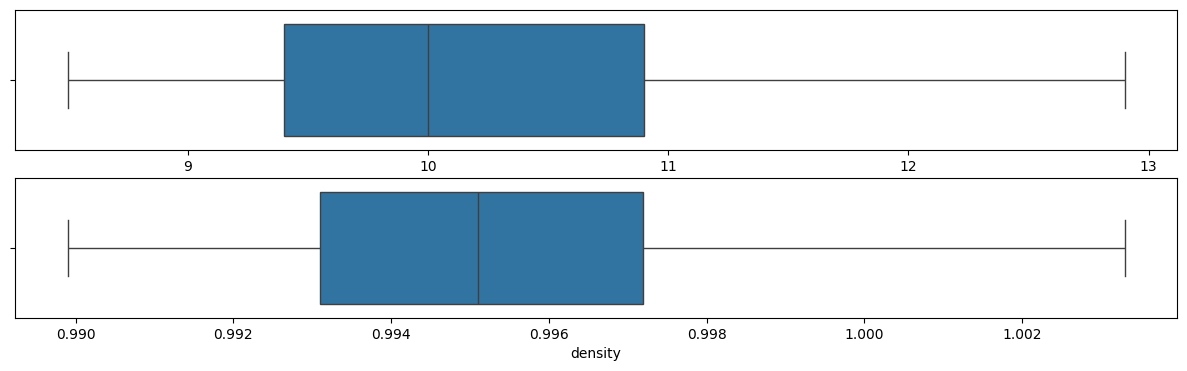

In [17]:
fig,ax = plt.subplots(2,1,figsize=(15,4))

sns.boxplot(data=data,x='alcohol',ax=ax[0])
sns.boxplot(data=data,x='density',ax=ax[1])

plt.show()


Tidak terdapat outlier pada variabel density.

`Imbalance Data`

Deteksi dan kuantifikasi proporsi label target

In [18]:
data['quality'].value_counts(normalize=True)*100

quality
0    81.683168
1    18.316832
Name: proportion, dtype: float64

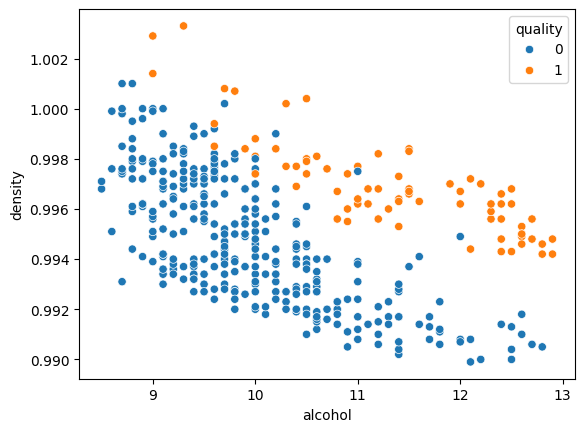

In [19]:
sns.scatterplot(data=data,x='alcohol',y='density',hue='quality')
plt.show()

Persentase jumlah label 0 (81.6%) lebih banyak dibandingkan label 1 (18.2%), ini termasuk imbalance.

`Check Multicollinearity`

Deteksi multicollinearity antar fitur dengan VIF.

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = data.drop(columns = 'quality')
y = data['quality']

vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values,i) for i in range (X.shape[1])]
vif['Feature'] = X.columns

vif.round(2)

,VIF Factor,Feature
0,88.56,alcohol
1,88.56,density


Terdapat multicollinearity antara fitur alcohol dan density. Saat menggunakan model linear, multicollinearity seharusnya dihindari. Namun untuk studi kasus ini kita akan pertahankan dahulu.

**Feature Engineering**

Bagi dataset menjadi train dan test set.

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .2, random_state =0, stratify=y)

In [22]:
print(f'y_train :\n{y_train.value_counts(normalize=True)}')

y_train :
quality
0    0.817337
1    0.182663
Name: proportion, dtype: float64


In [23]:
y.value_counts(normalize=True)

quality
0    0.816832
1    0.183168
Name: proportion, dtype: float64

### `Model Experiment`

**Estimating Coefficients**

In [24]:
logreg = sm.Logit(y_train, sm.add_constant(X_train))
result = logreg.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.093277
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:                quality   No. Observations:                  323
Model:                          Logit   Df Residuals:                      320
Method:                           MLE   Df Model:                            2
Date:                Tue, 17 Sep 2024   Pseudo R-squ.:                  0.8038
Time:                        14:39:18   Log-Likelihood:                -30.128
converged:                       True   LL-Null:                       -153.56
Covariance Type:            nonrobust   LLR p-value:                 2.488e-54
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2239.0362    405.881     -5.516      0.000   -3034.549   -1443.524
alcohol        5.4321      0

**P>|z| (Wald Test)**

- **const** = 0.000. pvalue < 0.05, reject Ho. That is, the model requires an intercept value.
- **alcohol** = 0.000. pvalue < 0.05, reject Ho. This means that alcohol has a significant negative effect on quality (the larger the alcohol, the larger the quality)
- **density** = 0.000. pvalue < 0.05, reject Ho. This means that density has a significant negative effect on quality (the larger the density, the larger the quality)


**Odd Ratio (OR)**

In [25]:
X_train.describe().loc[['min','max']]

,alcohol,density
min,8.5,0.9899
max,12.9,1.0033


`Alcohol`

In [26]:
beta = 5.4321
c = 10
d = 9

OR_alcohol = np.exp(beta*(c-d))
OR_alcohol

np.float64(228.62886226081392)

- Probability to good quality increases when alcohol increase
- Wine with alcohol 10 have about 228.62 times more likely to be good quality than wine with alcohol 9.

`Density`

In [27]:
beta = 2188.5305
c = 0.992
d = 0.991

OR_density = np.exp(beta*(c-d))
OR_density

np.float64(8.922092461787537)

- Probability to good quality increases when density increase
- Wine with density 0.992 have about 8.92 times more likely to be good quality than wine with density 0.991.

**Evaluating the Model**

In [28]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                quality   No. Observations:                  323
Model:                          Logit   Df Residuals:                      320
Method:                           MLE   Df Model:                            2
Date:                Tue, 17 Sep 2024   Pseudo R-squ.:                  0.8038
Time:                        14:39:18   Log-Likelihood:                -30.128
converged:                       True   LL-Null:                       -153.56
Covariance Type:            nonrobust   LLR p-value:                 2.488e-54
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2239.0362    405.881     -5.516      0.000   -3034.549   -1443.524
alcohol        5.4321      0.973      5.581      0.000       3.524       7.340
density     2188.5305    397.511      5.506      0.0

**Log Likelihood Ratio (LLR) Test**

- `Ho`: $\beta_1$ = $\beta_2$ = $\beta_3$ = $\beta_4$ = ..... = 0
- `Ha` : Not all coefficient ($\beta_i$) are 0 (there is at least 1 feature whose value ($\beta_i$) is not 0)
- $\alpha$: 0.05
- `LLR p-value` = 1.834e-47 < 0.05, reject Ho. We have enough evidence that density or alcohol affects the wine quality.


**Accuracy**

In [29]:
y_pred_proba = result.predict(sm.add_constant(X_test))
y_pred_proba

396    1.407489e-06
206    3.451388e-03
89     2.669679e-05
140    4.419259e-05
235    6.009217e-02
           ...     
180    5.988035e-04
176    3.425105e-04
365    4.668444e-05
51     4.977782e-07
220    9.990859e-01
Length: 81, dtype: float64

In [30]:
result.params

const     -2239.036223
alcohol       5.432143
density    2188.530480
dtype: float64

In [31]:
X_test.loc[396]

alcohol    10.0000
density     0.9921
Name: 396, dtype: float64

In [32]:
np.exp(-2239.036223 + 5.432143 * 10.0000 + 2188.530480 * 0.9921)

np.float64(1.4074882965907108e-06)

In [33]:
# prob > 0.5 --> 1
y_pred_class = np.where(y_pred_proba > 0.5,1,0)
y_pred_class

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1])

In [34]:
y_test

396    0
206    0
89     0
140    0
235    0
      ..
180    0
176    0
365    0
51     0
220    1
Name: quality, Length: 81, dtype: int64

In [35]:
from sklearn.metrics import accuracy_score

print(f'Akurasi model pada data set test : {accuracy_score(y_test,y_pred_class)}')
print(f'Dari {len(y_test)} botol wine maka {accuracy_score(y_test,y_pred_class)*len(y_test)} botol diprediksi dengan benar')

Akurasi model pada data set test : 0.9753086419753086
Dari 81 botol wine maka 79.0 botol diprediksi dengan benar


**Predict to New Data**

In [36]:
X.describe().loc[['min','max']]

,alcohol,density
min,8.5,0.9899
max,12.9,1.0033


In [37]:
new_data = pd.DataFrame({
    'alcohol' :[9,10,11,12],
    'density' :[.9899,.9999,1.0009,1.00023]
})
new_data

,alcohol,density
0,9,0.98990
1,10,0.99990
2,11,1.00090
3,12,1.00023


In [38]:
result.predict(sm.add_constant(new_data)).round(3)

0    0.000
1    0.973
2    1.000
3    1.000
dtype: float64